## Doublet prediction using scrublet: human-pig cd45 dataset 

##### In this notebook, we start with a raw counts matrix that was prior processed with soupX to remove ambient RNA. 
First, let's import the libraries we're going to use.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import matplotlib as mpl
import matplotlib.backends.backend_pdf
import session_info

import warnings
warnings.filterwarnings('ignore')

In [2]:
print("Versions used:- numpy:", np.__version__, "pandas:", pd.__version__, 
      "scanpy:", sc.__version__, "matplotlib:", mpl.__version__)


Versions used:- numpy: 1.23.3 pandas: 1.4.4 scanpy: 1.8.2 matplotlib: 3.5.2


Next, we'll read in the counts matrix generated by soupX

In [3]:
adata = sc.read_10x_mtx('/Users/Anchor/projects/xeno_manuscript/hpcd45/soupX_hpcd45_filt', cache=False)
adata.var_names_make_unique()

Let's take a look at the dataset. The full matrix contains 9085 cells and 41918 genes.


In [4]:
adata

AnnData object with n_obs × n_vars = 9085 × 41918
    var: 'gene_ids'

### Initialize Scrublet object
Refer to: https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb

The relevant parameters are:

expected_doublet_rate: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter. See Chromium User Guide: https://support.10xgenomics.com/permalink/3vzDu3zQjY0o2AqkkkI4CC for expected doublet rate
sim_doublet_ratio: the number of doublets to simulate, relative to the number of observed transcriptomes. This should be high enough that all doublet states are well-represented by simulated doublets. Setting it too high is computationally expensive. The default value is 2, though values as low as 0.5 give very similar results for the datasets that have been tested.
n_neighbors: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. The default value of round(0.5*sqrt(n_cells)) generally works well.


For the next step, we would need the expected doublet formation rate. These values can be found here: https://uofuhealth.utah.edu/huntsman/shared-resources/gba/htg/single-cell/genomics-10x

Since our dataset has 9085 (recovered) cells, we take the ~corresponding value ~7.6% for 10,000 recovered cells given in the table. This value can be adjusted accordingly. 

In [5]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate = 0.06)

## Run the default pipeline, which includes:

Doublet simulation
Normalization, gene filtering, rescaling, PCA
Doublet score calculation
Doublet score threshold detection and doublet calling

In [6]:
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_counts=2, min_cells=3, 
                                                          min_gene_variability_pctl=85, n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 32.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 10.4%
Elapsed time: 5.8 seconds


## Plot doublet score histograms for observed transcriptomes and simulated doublets

The simulated doublet histogram is typically bimodal. The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression. The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses. Scrublet can only detect neotypic doublets.

To call doublets vs. singlets, we must set a threshold doublet score, ideally at the minimum between the two modes of the simulated doublet histogram. scrub_doublets() attempts to identify this point automatically and has done a good job in this example. However, if automatic threshold detection doesn't work well, you can adjust the threshold with the call_doublets() function. For example:

scrub.call_doublets(threshold=0.25)

The following histogram is an important diagnostic plot. Doublet score threshold should separate the two shoulders of the bimodal distribution. If this is not so, adjust the soublet score cutoff accordingly.

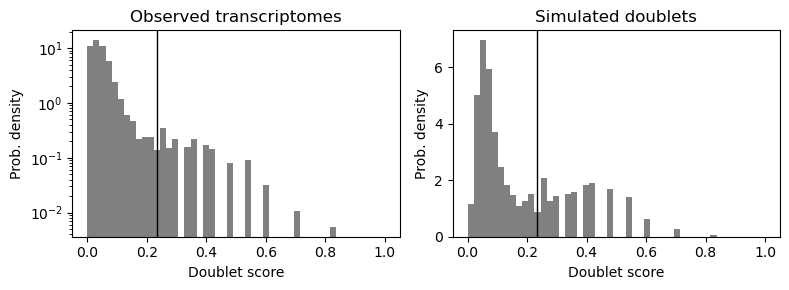

In [7]:
scrub.plot_histogram()

pdf = matplotlib.backends.backend_pdf.PdfPages("/Users/Anchor/projects/xeno_manuscript/hpcd45/scrublet_predictions/doublet_predictions_histogram.pdf")
for fig in range(1, 2): 
    pdf.savefig( fig )
pdf.close() 

Let's visualize the doublet predictions in a 2-D embedding. Predicted doublets should mostly co-localize (possibly in multiple clusters). If they do not, you may need to adjust the doublet score threshold, or change the pre-processing parameters to better resolve the cell states present in your data. In our case, everything appears to be in order.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


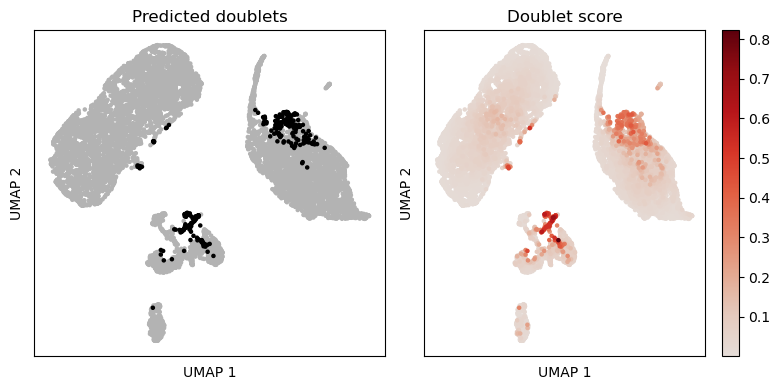

In [8]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True);

pdf = matplotlib.backends.backend_pdf.PdfPages("/Users/Anchor/projects/xeno_manuscript/hpcd45/scrublet_predictions/doublet_predictions_UMAP.pdf")
for fig in range(1 ,2):
    pdf.savefig( fig )
pdf.close()

In [9]:
adata.obs

,doublet_scores,predicted_doublets
AAACCCAAGATTCGAA-1,0.010337,False
AAACCCAAGTGCCTCG-1,0.041447,False
AAACCCACAACCGACC-1,0.036266,False
AAACCCACACCTTCGT-1,0.029327,False
AAACCCACACTAGGCC-1,0.088853,False
...,...,...
TTTGTTGGTAGCGAGT-1,0.075558,False
TTTGTTGGTATACGGG-1,0.175819,False
TTTGTTGTCACAAGAA-1,0.032613,False
TTTGTTGTCAGAGTTC-1,0.043744,False


Finally, let's save a tab-separated file of doublet calls and doublet scores - it will be used for further downstream analyses including filtering for doublet removal.

In [10]:
adata.obs['predicted_doublets'].value_counts()

False    8782
True      303
Name: predicted_doublets, dtype: int64

In [11]:
pd.DataFrame(adata.obs).to_csv("/Users/Anchor/projects/xeno_manuscript/hpcd45/scrublet_predictions/scrublet_calls.csv",header = True)

In [12]:
session_info.show()